# The Up-Dn System 

### Marco Arieli Herrera-Valdez
#### Laboratorio de Dinámica, Biofísica, y Fisiología de Sistemas, Facultad de Ciencias, UNAM
Last modified: 20230101

$\nu$ is the membrane potential

$\nu \mapsto v = \nu/\nu_T$ to simplify notation

\begin{eqnarray}
\partial_t v &=& J_F - J_{U}(v,w) - J_D(v,w) - J_{UD}(v)\\
\partial_t w &=& w^\kappa \left[ \alpha_w(v)(1-w) -  \beta_w(v) w \right]
\end{eqnarray}


### Auxiliary functions

Auxiliary functions
\begin{eqnarray}
\alpha_i (v; v_i, b_i, z_i) &=& r_i \exp \left[b_i z_i (v-v_i)  \right], \quad \textrm{forward rate}
\\
\beta_i (v; v_i, b_i, z_i) &=& r_i \exp \left[(b_i-1) z_i (v-v_i)  \right], \quad \textrm{backward rate}
\\
\sigma_i (v; v_i) &=& \frac{\alpha_i(v)}{\alpha_i(v)+ \beta_i(v)} = \frac{1}{1+ \exp \left[z_i (v_i-v)  \right]}, \quad \textrm{steady state} 
\\
J_U(v,w) &=& N_U r_U m_{\infty}(v) (1-w) \left[ \alpha_U(v) - \beta_U(v) \right], \quad \textrm{Up flow} 
\\
J_D(v,w) &=& N_D r_D w \left[ \alpha_D(v) - \beta_D(v) \right], \quad \textrm{Dn flow} 
\\
J_{UD}(v,w) &=& N_{UD} r_{UD} w \left[ \alpha_{UD}(v) - \beta_{UD}(v) \right], \quad \textrm{UpDn pump flow} 
\end{eqnarray}

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import numpy as np
import numpy.linalg as la
from numpy.random import uniform
import matplotlib.pylab as pl
import sympy as sy
from sympy.plotting import plot, PlotGrid, plot3d
from sympy.utilities.iterables import flatten
import time
%matplotlib notebook
#%matplotlib inline


In [2]:
def delDictItem(d,key):
    r = d.copy()
    del(r[key])
    return r

def dictMerge(dict1, dict2):
    return(dict2.update(dict1))

def biasedExp(x,a,b=1):
    return sy.exp(b * (x-a))

def sigmoid(x,a,n=1):
    xn = x**n
    return xn /(xn + a**n)

def secant_method(f, x0, x1, tol=1e-5, n=0):
    n += 1 # increment counter
    y0, y1 = f(x0), f(x1) # calculate function values at endpoints
    xn = x1 - y1 * ((x1 - x0) / (y1 - y0)) # calculate next root approximation
    if -tol < y1 < tol: # check tolerance condition
        return xn, n
    # recursive call with updated interval
    return secant_method(f, x1, xn, n=n)
# ----------------------
# Numerics
# ----------------------

def RK2_autonomousStep(f, U, stepSize):
    k = stepSize * f(U) / 2
    return U + stepSize * f(U + k)

def RK2_nonautonomousStep(f, U, p, stepSize):
    k = stepSize * f(U,p) / 2
    return U + stepSize * f( U + k, p)


# ----------------------
# Bifurcation
# ----------------------
def fixedPoint2D_typeMarker(eigenValues,ms=5,color_nodo='orange',color_foco='blue'):
    pf=dict()
    l1,l2 = eigenValues
    r1,r2 = np.real(eigenValues)
    i1,i2 = np.imag(eigenValues)
    pf['eigVal_1'] = l1; pf['eigVal_2']=l2; pf['r1']=r1; pf['r2']=r2; pf['i1']=i1; pf['i2']=i2;
    pf['transp'] = 1; pf['mfc']= 'white'; pf['ms']= ms
    if (i1*i2<0): 
        pf['type']='focus';pf['mec']=color_foco;
        if r1>0: 
            pf['localDyn']='repeller'; pf['marker']='o'; pf['mfc'] ='white'; 
        elif r1<0:
            pf['localDyn']='attractor'; pf['marker']='o'; pf['mfc'] =color_foco
        else:
            pf['localDyn']='centre'; pf['marker']='o'; pf['mfc']= 'gray'; pf['mec']= 'cyan'; pf['ms']=1.5*ms
    else: 
        pf['type']='node'; pf['mec']=color_nodo; 
        if (r1*r2) < 0:
            pf['localDyn'] ='saddle'; pf['marker']='x'; pf['mfc']=color_nodo; pf['ms'] = 2*ms
        elif (r1*r2>0):
            if r1>0: pf['localDyn']='repeller'; pf['marker']='o'; pf['mfc'] ='white' 
            if r1<0: pf['localDyn']='attractor'; pf['marker']='o'; pf['mfc'] =color_nodo 
        elif (r1*r2 == 0) | (r1*r2<1e-15): 
            pf['localDyn']='degen'; pf['marker']='o'; pf['mfc']= 'lightgray'; pf['mec']= 'cyan'; pf['ms']=1.5*ms
    return pf


Transformation of the slow variable for comparison with $v$
    \begin{eqnarray}
    w_{\infty} &=& \left\{ 1 + \exp \left[ g_w (v_w - v\right] \right]^{-1} \\
    v_{w\infty} &=& v_w - \frac{1}{g_w} \log \left( \frac{1}{w_{\infty}} - 1 \right)  
    \end{eqnarray}

### Up-Dn class



In [3]:
class system2D: 
    
    def __init__(self, params, variables=('x','y')):
        self.vars = variables
        self.pars = params.copy();
        self.pars_orig = params.copy()
        self.dict2symbols(params)
        self.createStateVars(variables)
        self.pars['stepSize'] = self.pars['timeStep']
        #self.defineFunctions()
        #self.updateFunctions()
        return
    
    def createStateVars(self,variables):
        print("Setting %s and %s as state variables"%(variables[0],variables[1]))
        str1 = "self.%s, self.%s = sy.symbols(%s)"%(variables[0],variables[1],variables)
        print(str1)
        return exec(str1)
    
    def resetParameters(self):
        print('Resetting dictionary to the original', self.pars_orig); self.pars = self.pars_orig.copy(); 
        return 
        
    def dict2symbols(self,di):
        for k in di.keys():
            exec("self.%s = sy.Symbol('%s')"%(k,k))
        return
    
    def nuFu_expr(self, expression, variables):
        str1 = "self.%s_ = sy.lambdify(%s, self.%s.subs(self.pars), 'numpy')"%(expression, variables, expression)
        #print(str1)
        return exec(str1)
    
    def trayectory_Autonomous(self,f):
        self.timeSamples = np.arange(self.pars['timeMin'], self.pars['timeMax'], self.pars['timeStep'])
        self.nSteps = len(self.timeSamples)            
        U = np.zeros((self.nSteps, np.prod(np.shape(self.pars['ic']))),"float64")
        U[0] = self.pars['ic']
        for i in range(self.nSteps-1):
            U[i+1] = RK2_autonomousStep(f, U = U[i], stepSize = self.pars['timeStep'])
        return U.transpose()
    
    def subsJacobian(self):
        self.sysJacobian =  self.evolution.subs(self.pars).jacobian(self.vars)
        return 
        
    def eigvaluesFromFP(self,fp):
        ws,vs = fp
        self.subsJacobian()
        self.nuFu_expr(expression= 'sysJacobian', variables=self.vars)
        return la.eigvals(self.sysJacobian_(ws,vs))
    
    def parameterFromFP(self, fp, parName):
        wStar,vStar = fp; #print('Fixed point: ',fp)
        pp = self.pars.copy(); pp.pop(parName); 
        #print(self.J_inf.subs(pp).subs({'w':wStar, 'v':vStar}))
        fpEq = sy.Eq( self.ssEquation.subs(pp).subs( [(self.vars[0],wStar),(self.vars[1],vStar)], 0))
        return np.float64(sy.solve(fpEq, parName)[0])
    
    def fpType(self,eigenValues, ms=5, nodeColor='orange',focusColor='blue'):
        return fixedPoint2D_typeMarker(eigenValues, ms, nodeColor, focusColor)

    def cod1FPs(self, fps, parName, ms=5, nodeColor='blue', focusColor='gray'):
        """Inputs:
        fps ~ list of fixed points (each entry is an ordered pair, tuple, or array)
        """
        tStart = time.process_time()
        pp = dict(p); 
        pp.pop(parName)
        cod1 = list()
        nfp = len(fps)
        fps = list(); parValues = list(); evs = list(); fpTypes=list()
        for n in range(nfp): 
            parValues.append(self.parameterFromFP(fps[n],parName))
            self.pars[parName] = parValues[n]
            self.nuFu_Jacobian_subsPars()
            evs.append(self.eigvaluesFromFP(fps[n]))
            #print('(parameter, ev)=(%g,%g)'%(pv,ev))
            fpTypes.append(self.fpType(evs[n], ms, nodeColor, focusColor))
        cod1={ 'fps':fps, 'parName': parValues, 'evs':evs, 'fpTypes':fpTypes, 'nFPs':nfp}
        print('Took %d seconds to calculate the fixed point list for %s'%(time.process_time()-tStart, parName))
        return cod1
    
    def bifurcationDiagram_Cod1(self, ax, fps, coordinate, parName, nodeColor='gray', focusColor='gray', yLabel=''):
        cod1 = self.cod1FPs(fps, parName = parName, ms=3, color_nodo=nodeColor,color_foco=focusColor)
        for n in range(cod1['nFPs']):
              fpt= cod1['fpTypes'][n]
              ax.plot(cod1['parName'][n], cod1['fps'][n][coordinate],fpt['marker'], \
                    markerfacecolor=fpt['mfc'], markeredgecolor=fpt['mec'])
        ax.set_xlabel(parName); 
        ax.set_ylabel(yLabel)
        self.pars = self.pars_orig
        return cod1  



In [26]:
class UD(system2D):
    def __init__(self, params,variables):
        super().__init__(params,variables)
        self.defineFunctions()
        #self.updateFunctions()
        return
    
    def defineFunctions(self):
        print("Defining all functions. Notice v is normalized by v_T")
        self.e_m = biasedExp( x=self.v, a=self.v_m, b=self.g_m)
        self.e_w = biasedExp( x=self.v, a=self.v_w, b=self.g_w)
        self.e_U = biasedExp( x=self.v, a=self.v_U, b=1)
        self.e_D = biasedExp( x=self.v, a=self.v_D, b=1)
        self.e_UD = biasedExp( x=self.v, a=self.v_UD, b=1)
        self.alpha_w = self.r_w * (self.e_w ** self.b_w)
        self.beta_w = self.r_w * (self.e_w ** (self.b_w-1))
        self.alpha_U = self.r_U * (self.e_U ** self.b_U)
        self.beta_U = self.r_U * (self.e_U ** (self.b_U-1))
        self.alpha_D = self.r_D * (self.e_D ** self.b_D)
        self.beta_D = self.r_D * (self.e_D ** (self.b_D-1))
        self.alpha_UD = self.r_UD * (self.e_UD ** self.b_UD)
        self.beta_UD = self.r_UD * (self.e_UD ** (self.b_UD-1))
        self.tau_w = 1/ (self.alpha_w + self.beta_w)
        self.m_inf = self.e_m / ( 1 + self.e_m)
        self.w_inf =  self.e_w / (1 + self.e_w)
        self.v_w_inf = (self.v_w - sy.log(1/self.w - 1))/self.g_w
        self.J_U = self.a_U * self.m_inf * (1-self.w) * (self.alpha_U - self.beta_U)
        self.J_D = self.a_D * self.w * (self.alpha_D - self.beta_D)
        self.J_UD = self.a_UD * (self.alpha_UD - self.beta_UD)
        self.dv = self.a_F - self.J_U - self.J_D - self.J_UD
        self.dw = self.w**self.kappa_w * (self.alpha_w - (self.alpha_w + self.beta_w)*self.w )
        self.w_vNull = (self.a_F - self.J_UD - self.a_U * self.m_inf * (self.alpha_U - self.beta_U)) \
        / (self.a_D * (self.alpha_D - self.beta_D) - self.a_U * self.m_inf * (self.alpha_U - self.beta_U))
        self.evolution = sy.Matrix([self.dw,self.dv])
        self.ssEquation = self.dv.subs({'w': self.w_inf})
        return
    
    def updateFunctions(self):
        self.nuFu_expr(expression='dw',variables=['w','v'])
        self.nuFu_expr(expression='dv',variables=['w','v'])
        self.nuFu_expr(expression='m_inf',variables=['v'])
        self.nuFu_expr(expression='w_inf',variables=['v'])
        self.nuFu_expr(expression='w_vNull',variables=['v'])
        self.nuFu_expr(expression='J_UD',variables=['v'])
        self.nuFu_expr(expression='J_U',variables=['w','v'])
        self.nuFu_expr(expression='J_D',variables=['w','v'])
        self.nuFu_expr(expression='ssEquation',variables=['v'])
        return 
    
    def phasePlane(self, ax, W = np.linspace(0,1,50), V = np.linspace(-60,30,200)/26.64, wNullLabel='', vNullLabel='',plotNullClines=1):
        self.nuFu_expr(expression='dw',variables=['w','v'])
        self.nuFu_expr(expression='dv',variables=['w','v'])
        self.nuFu_expr(expression='w_inf',variables=['v'])
        self.nuFu_expr(expression='w_vNull',variables=['v'])
        Wgrid,Vgrid = np.meshgrid(W, V)
        dV = self.dv_(Wgrid,Vgrid); dW = self.dw_(Wgrid,Vgrid); 
        ax.streamplot(W,V*self.pars['v_T'],dW,dV*self.pars['v_T'], color = 'gray',linewidth=1);
        if plotNullClines>0:
            w_wNull = self.w_inf_(V); w_vNull = self.w_vNull_(V)
            ax.plot(w_vNull, V*self.pars['v_T'], lw=2,   color = 'green', alpha=0.75);
            ax.plot(w_wNull, V*self.pars['v_T'], lw=2, color = 'orange', alpha=0.75)
        return ax
    
    def iClampSquareStims(self, iLevels, timeStimStart, timeStimStop):
        nLevels = len(iLevels)
        iAmps = list()
        self.timeSamples = np.arange(self.pars['timeMin'],self.pars['timeMax'],self.pars['timeStep'])
        self.nSteps = len(self.timeSamples)
        a = np.int64(np.ceil( (timeStimStart-self.pars['timeMin'])/self.pars['timeStep']))
        b = np.int64(np.floor( (timeStimStop-self.pars['timeMin'])/self.pars['timeStep']))
        for n in range(nLevels):
            iAmps.append(np.zeros(self.nSteps))
            iAmps[n][a:b] = iLevels[n]
        return iAmps
    
    def dvw_(self,U):
        return np.array([self.dw_(*U),self.dv_(*U)])

    def trayectory_nonAutonomous(self, parNames=[], parVals=[]):
        '''
        parNames and parVals must be lists of the same length. 
        Each element in parVals must have the same length as the timeSample vector
        '''     
        self.timeSamples = np.arange(self.pars['timeMin'],self.pars['timeMax'],self.pars['timeStep'])
        self.nSteps = len(self.timeSamples)            
        nPars = len(parNames)

        diNP = self.pars.copy()
        for n in range(nPars):
            diNP = delDictItem(diNP,parNames[n])
    
        self.dwPars_ = sy.lambdify(self.vars+parNames, self.dw.subs(diNP), 'numpy')
        self.dvPars_ = sy.lambdify(self.vars+parNames, self.dv.subs(diNP), 'numpy')
        fPars = lambda Upars : np.array([self.dwPars_(*Upars),self.dvPars_(*Upars)])
        U = np.zeros((self.nSteps, np.prod(np.shape(self.pars['ic']))),"float64")
        U[0]=self.pars['ic'] 
        for nn in range(self.nSteps-1):
            pars = np.array([parVals[n][nn] for n in range(nPars)])
            UPars = np.hstack( [U[nn], pars])
            k = self.pars['timeStep'] * fPars(UPars) / 2
            kPars = np.hstack( [k, pars])
            U[nn+1] = U[nn] + self.pars['timeStep'] * fPars( UPars + kPars)
        self.updateFunctions()
        return U.transpose()            
            
    def getDynamics(self, parNames=[], parVals=[]):
        upDn.updateFunctions()
        if len(parNames)==0: 
            self.wOrbit, self.vOrbit = self.trayectory_Autonomous(self.dvw_)
        else: 
            self.wOrbit, self.vOrbit = self.trayectory_nonAutonomous(parNames, parVals)
        self.uOrbit = self.vOrbit * self.pars['v_T']
        self.dudt = np.zeros(len(self.uOrbit))
        self.dudt[1:] = (self.uOrbit[1:]-self.uOrbit[:-1])/upDn.pars['timeStep']
        print('Max dv/dt = %g V/s'% self.dudt.max())
        self.v_w_inf = self.pars['v_w'] - np.log(1/self.wOrbit -1)/self.pars['g_w']
        self.I_U = self.pars['vTCm'] * self.J_U_(self.wOrbit,self.vOrbit)  
        self.I_D = self.pars['vTCm'] * self.J_D_(self.wOrbit,self.vOrbit) 
        self.I_UD = self.pars['vTCm'] * self.J_UD_(self.vOrbit)
        return self.wOrbit, self.vOrbit
    
    def plotDynamicProfile(self,ax, vMin = -80, vMax = 40, iMin=-20, iMax=70, wMin=0, wMax=1): 
        #
        print(type(self.v),type(self.w))
        ax[0].plot(self.timeSamples, self.uOrbit, color='black', label=r'$(t,v)$')
        ax[0].plot(self.timeSamples, self.pars['v_T']*self.v_w_inf, '--', color='black', label=r'$(t,w_{\inf}^{-1}(w))$')
        ax[0].set_xlabel(r'time (ms)'); ax[0].set_ylabel(r'mV')
        ax[0].set_ylim(vMin,vMax); ax[0].legend()
        ax[1].plot(self.dudt, self.uOrbit, color='black', label=r'$(\partial_t v, v)$')
        ax[1].plot(self.dudt, self.pars['v_T']*self.v_w_inf, '--', color='black', label=r'$(\partial_t v, w_{\inf}^{-1}(w))$')
        ax[2].plot(self.wOrbit, self.uOrbit, color='black', label=r'$(w, v)$')
        #ax[2].plot(self.wOrbit, self.pars['v_T']*self.v_w_inf, '--', color='black', label=r'$(w, w_{\inf}^{-1}(w))$')
        self.phasePlane(ax[2], V=np.linspace(vMin,vMax,300)/v_T, W=np.linspace(wMin,wMax,200))
        for nn in range(3): ax[nn].set_ylim(vMin,vMax);
        ax[3].plot(self.timeSamples, self.I_U, color='green', label=r'$I_{U}$')
        ax[3].plot(self.timeSamples, self.I_D, color='orange', label=r'$I_{D}$')
        ax[3].set_xlabel(r'time (ms)'); ax[3].set_ylabel(r'pA');
        ax[6].plot(self.timeSamples, self.I_UD, color='blue', label=r'$I_{UD}$')
        ax[6].set_xlabel(r'time (ms)'); #ax[6].set_ylabel(r'pA'); 
        ax[6].set_ylim(iMin,iMax); #ax[6].set_ylabel(r'mV'); 
        ax[7].plot(self.dudt, self.I_UD, color='blue', label=r'$I_{UD}$')
        ax[4].plot(self.dudt, self.I_U, color='green', label=r'$I_{U}$')
        ax[4].plot(self.dudt, self.I_D, color='orange', label=r'$I_{D}$')
        ax[8].plot(self.wOrbit, self.I_UD, color='blue', label=r'$(w,I_{UD})$')
        ax[5].plot(self.wOrbit, self.I_U, color='green', label=r'$(w,I_{U})$')
        ax[5].plot(self.wOrbit, self.I_D, color='orange', label=r'$(w,I_{UD})$')
        ax[7].set_xlabel(r'$\partial_t v(t)$ (V/s)'); 
        ax[7].set_ylabel(r'pA'); ax[7].set_ylim(iMin,iMax);
        for nn in range(6,9): ax[nn].set_ylim(iMin,iMax);
        #pl.ion(); pl.draw()
        for nn in range(9):  ax[nn].legend()
        return ax


### UpDn class instance


In [27]:
eCharge=1.60217733e-19 # Coulombs; 
kBoltzmann=1.38065812e-20 #mJ/K
zeroT=273.15 #deg Kelvin
TCelcius = 36
v_T = kBoltzmann * (zeroT + TCelcius)/ eCharge
C_m = 20.0; vTCm= v_T * C_m
print(r'v_T=%g, C_m=%g, v_T C_m= %g'%(v_T,C_m, vTCm))

voltages = {'v_w':-10.0/v_T, 'v_m': -20.0/v_T,'v_U':60.0/v_T, 'v_D':-90.0/v_T, 'v_UD':-80.0/v_T}
biases = {'b_w':0.35, 'b_U':0.5, 'b_D':0.3, 'b_UD':0.1, 'g_m':4, 'g_w':2.15}
rates = {'r_w':0.25, 'a_F': 0*100 / vTCm, 'r_U':1, 'r_D':1, 'r_UD':1e-4, 'a_U': 4, 'a_D': 10, 'a_UD':1000}
numerics = {'timeMin': -1.0, 'timeMax':300.0, 'timeStep':1/40.0, 'ic': np.array([0.0001, -60.0/v_T]),\
            'vMin':-100/v_T,'vMax':40/v_T, 'wMin':0,'wMax':1, 'vStep':0.1,'wStep':0.01}
p = {'v_T': v_T, 'C_m':C_m, 'vTCm': v_T * C_m, 'kappa_w':0.35}
p= {**p, **voltages, **biases, **rates, **numerics}
upDn = UD(params= p, variables=['w','v'])
upDn.vRange = np.arange(upDn.pars['vMin'],upDn.pars['vMax'],upDn.pars['vStep'])
upDn.wRange = np.arange(upDn.pars['wMin'],upDn.pars['wMax'],upDn.pars['wStep'])

v_T=26.6407, C_m=20, v_T C_m= 532.813
Setting w and v as state variables
self.w, self.v = sy.symbols(['w', 'v'])
Defining all functions. Notice v is normalized by v_T


## Stream vectors and the effects of activation parameters on the nullclines

The nullclines of the system are given by the curves
\begin{eqnarray}
    w_{vNull} &=& \frac{J_F - a_{UD}  \left[ \alpha_{UD}(v) - \beta_{UD}(v) \right] - a_U m_{\infty}(v) \left[ \alpha_U(v) - \beta_U(v) \right] }
    { a_{D}  \left[ \alpha_{D}(v) - \beta_{D}(v) \right] - a_U m_{\infty}(v) \left[ \alpha_U(v) - \beta_U(v) \right] }
    \\
    w_{wNull} &=& \frac{ \alpha_w(v)}{\alpha_w(v)+\beta_w(v)} = \frac{1}{1 + \exp \left[ (v_w - w) g_w\right]}
\end{eqnarray}

The system may have 1, 2 (seldom), or 3 fixed points. The system is more likely to have 3 fixed points if the slope of the $w$-nullcline is smaller than the slope of the $v$-nullcline, and both curves are very close to each other.

One important combination of parameters is the pair $(v_w, g_w)$. Larger values of $v_w$ shift the $w$-nullcline to the right, while larger values of $g_w$ bend the $w$-nullcline so that the curve is at higher points for smaller values of $v$. This means that the intersection between the $w$- and $v$-nullclines can shift toward larger $v$ values for smaller values of $g_w$, or for larger values of $v_w$. 


## Dynamics

In [ ]:
upDn.pars['v_m']= -20.0/v_T; upDn.pars['g_m']= 4;  
upDn.pars['v_w']= -10.0/v_T; upDn.pars['g_w']= 2.4; upDn.pars['b_w'] = 0.65; upDn.pars['kappa_w']=0.35; upDn.pars['r_w'] = 0.25
upDn.pars['b_D']= 0.3; #upDn.pars['b_UD']= 0.8
upDn.pars['a_F'] = 0 / vTCm; # 70 pA en rheobase 
upDn.pars['a_U'] = 4.; upDn.pars['a_D'] = 6; upDn.pars['a_UD'] = 800;
upDn.pars['timeMax'] = 30.0; upDn.pars['timeStep']=1/50.0; upDn.pars['ic'] = np.array([0.001, -50.0/v_T])
#
upDn.getDynamics()
f = pl.figure(figsize=(11,9)); #pl.ioff(); 
ax = list(); rows = 1; cols= 3;
for n in range(rows*cols):
    ax.append(f.add_subplot(rows,cols,n+1))

Max dv/dt = 292.002 V/s


<IPython.core.display.Javascript object>


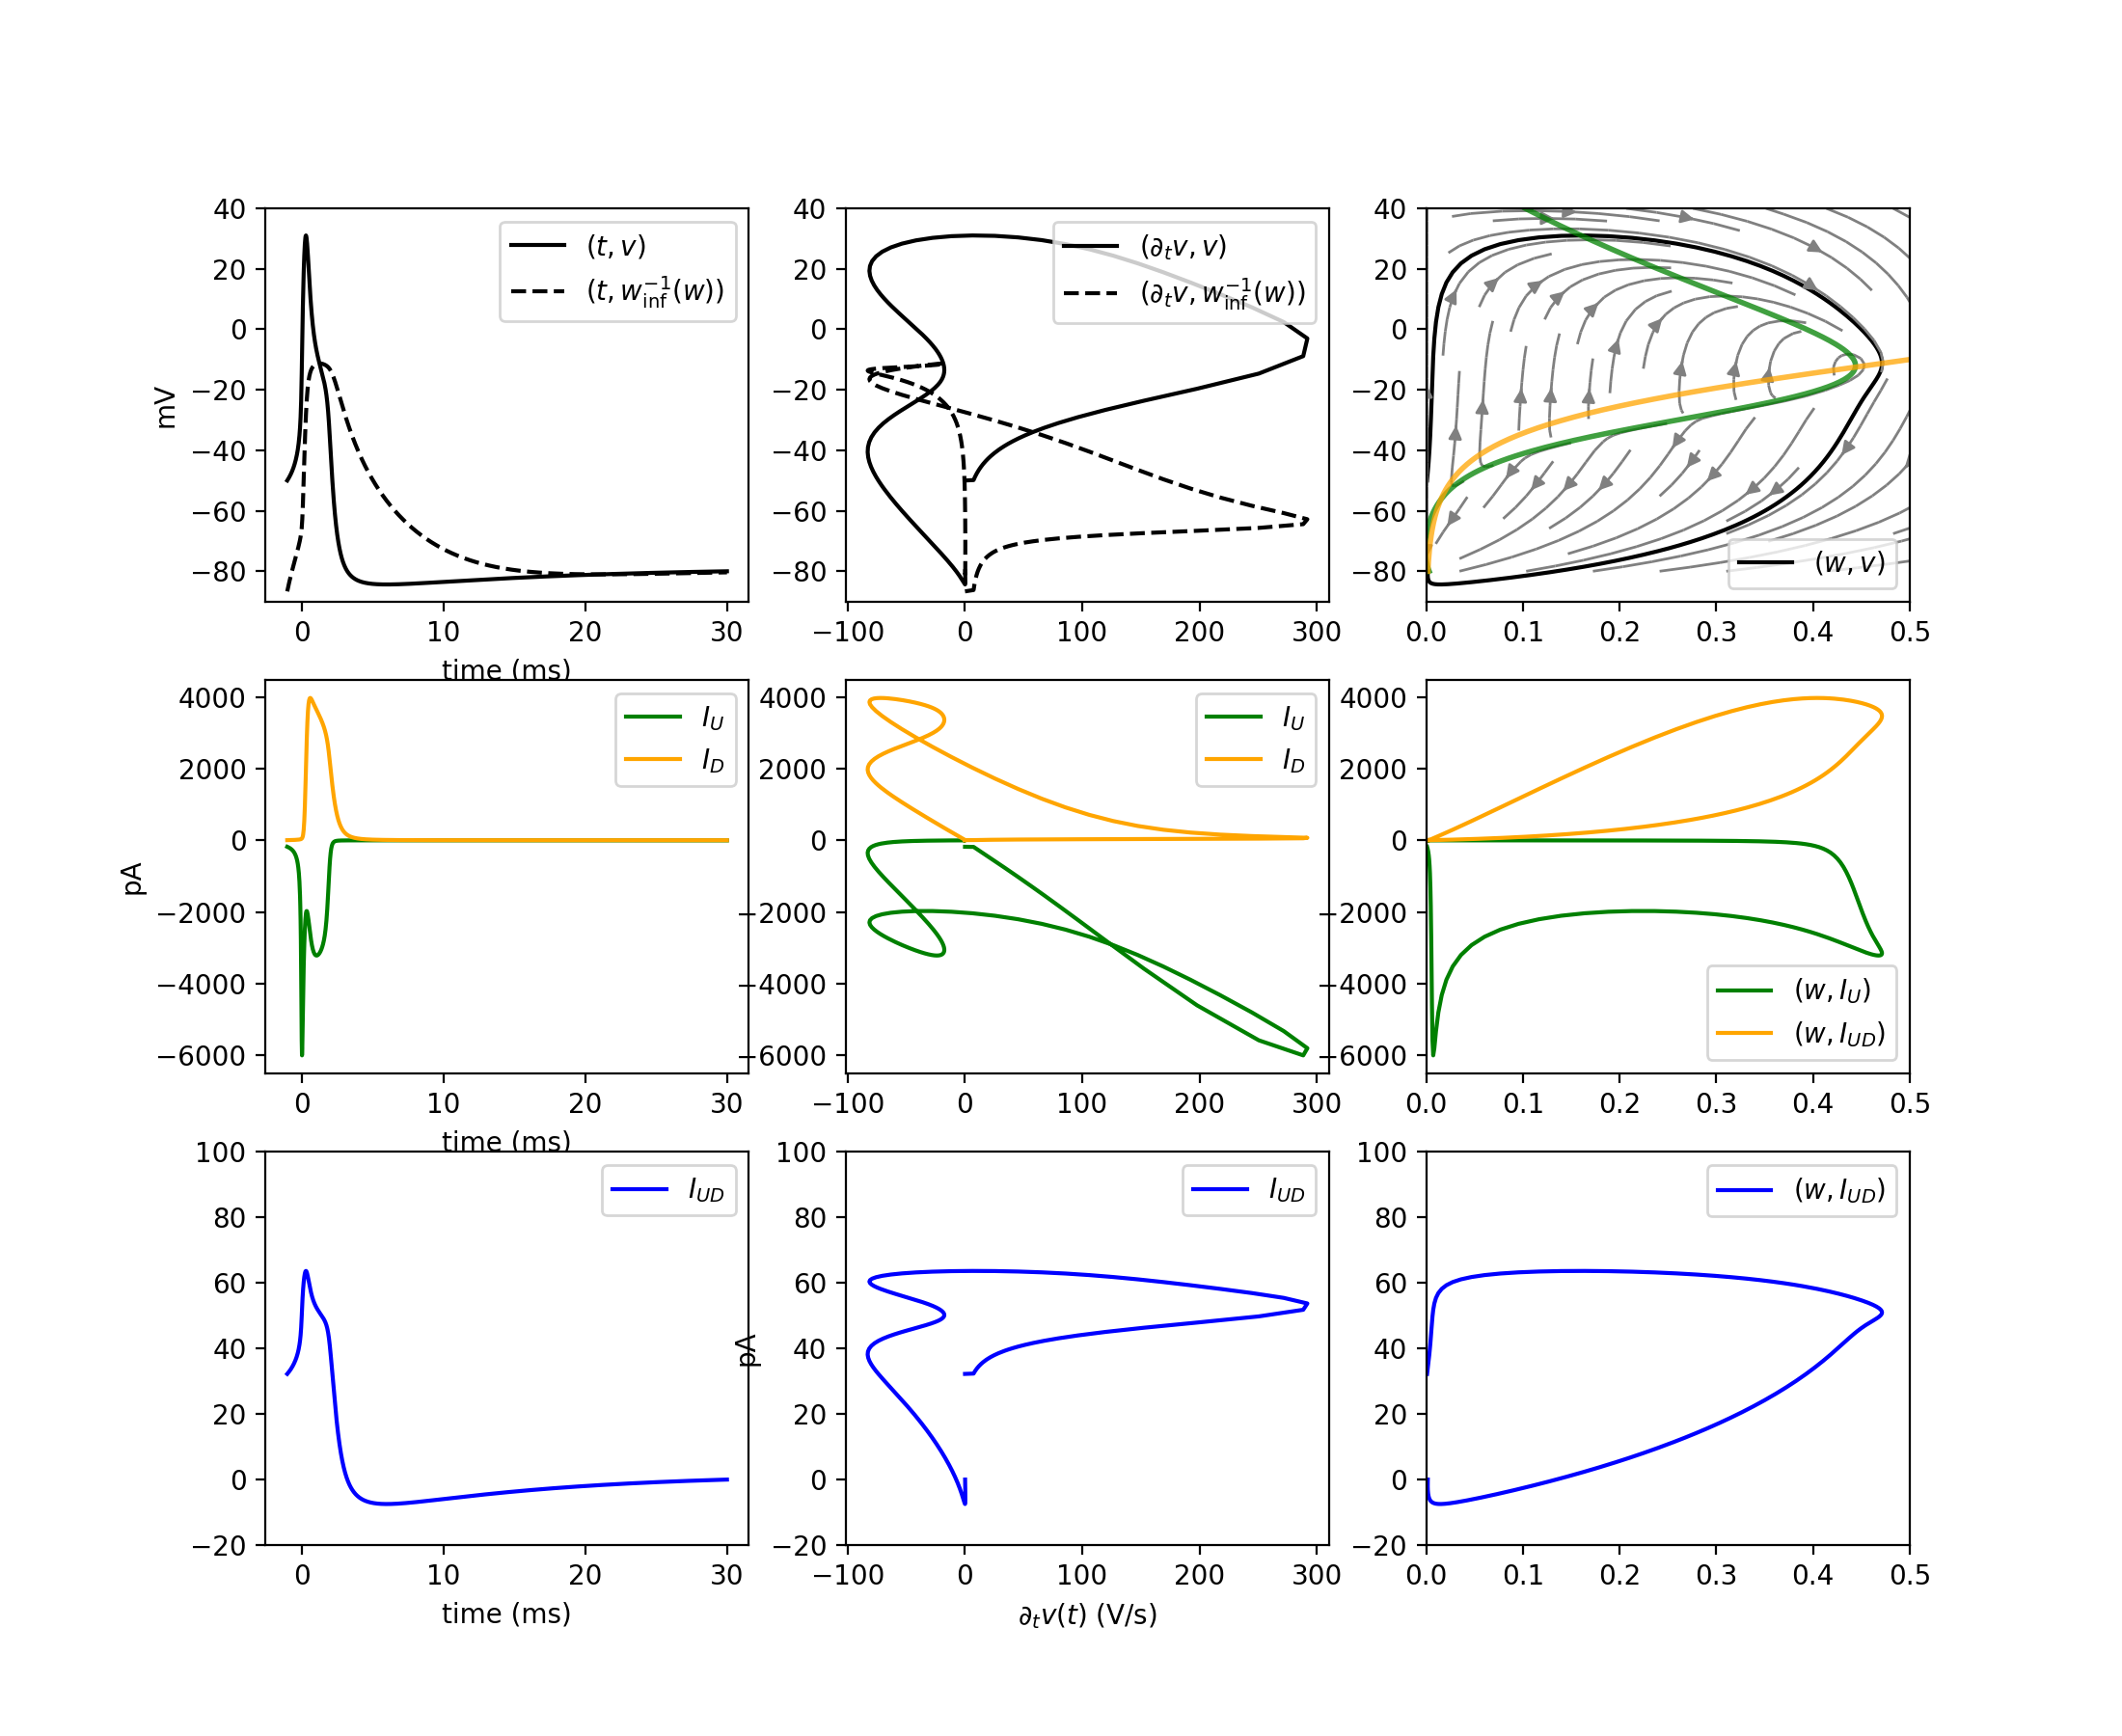

<class 'sympy.core.symbol.Symbol'> <class 'sympy.core.symbol.Symbol'>
a_F = 0


In [28]:
upDn.pars['v_m']= -20.0/v_T; upDn.pars['g_m']= 4;  
upDn.pars['v_w']= -10.0/v_T; upDn.pars['g_w']= 2.4; upDn.pars['b_w'] = 0.65; upDn.pars['kappa_w']=0.35; upDn.pars['r_w'] = 0.25
upDn.pars['b_D']= 0.3; #upDn.pars['b_UD']= 0.8
upDn.pars['a_F'] = 0 / vTCm; # 70 pA en rheobase 
upDn.pars['a_U'] = 4.; upDn.pars['a_D'] = 6; upDn.pars['a_UD'] = 800;
upDn.pars['timeMax'] = 30.0; upDn.pars['timeStep']=1/50.0; upDn.pars['ic'] = np.array([0.001, -50.0/v_T])
#
upDn.getDynamics()
f = pl.figure(figsize=(11,9)); #pl.ioff(); 
ax = list(); rows = 3; cols= 3;
for n in range(rows*cols):
    ax.append(f.add_subplot(rows,cols,n+1))
ax=upDn.plotDynamicProfile(ax)
for nn in [2,5,8]:
    ax[nn].set_xlim(0,0.5)
for nn in [0,1,2]:
    ax[nn].set_ylim(-90,40)
    ax[nn+6].set_ylim(-20,100)
#
print('a_F = %g'%upDn.pars['a_F'])


### I-Clamp

In [30]:
upDn.pars['timeMax'] = 300.0; upDn.pars['ic'] = np.array([0.001,-80.0/v_T])

iAmps = upDn.iClampSquareStims(iLevels=np.arange(-10,150,25)/upDn.pars['vTCm'], timeStimStart=100, timeStimStop=200)
nCommands = len(iAmps)

wOrbits = list(); vOrbits = list()  
for n in range(nCommands):
    wOrbit, vOrbit = upDn.trayectory_nonAutonomous(parNames=['a_F'], parVals=[iAmps[n]])
    wOrbits.append(wOrbit);     vOrbits.append(vOrbit)
    
f = pl.figure(figsize=(9,4))
ax = f.add_subplot(212); bx = f.add_subplot(211)
hShift = 10; vShift = 20; tMin = -50; tMax = upDn.pars['timeMax']
for n in range(nCommands):
    bx.plot(upDn.timeSamples - n*hShift, vOrbits[n]*upDn.pars['v_T'] + n*vShift)
    ax.plot(upDn.timeSamples, iAmps[n]*upDn.pars['vTCm'], '.', ms = 1)
    ax.set_xlim(tMin,tMax); bx.set_xlim(tMin,tMax)

upDn.resetParameters()
#upDn.pars['v_w'] =10/upDn.pars['v_T']
upDn.nuFu_expr(expression='ssEquation',variables=['v'])
upDn.nuFu_expr(expression='w_inf',variables=['v'])
J_inf = upDn.ssEquation_(upDn.vRange)
print(J_inf.sort)
x0s = [-3.1,-1.1,-0.46 ]; x1s = [-2.,-0.7,-0.25]
nfps = len(x0s)
fps = np.zeros((nfps,2),'float64')
evs = list(); fpTypes =list()
for nn in range(nfps):
    v_star, nIter = secant_method(f = upDn.ssEquation_, x0=x0s[nn], x1=x1s[nn], tol=1e-4, n=0)
    fps[nn] = np.array([upDn.w_inf_(v_star),v_star])
    print("Fixed point at (%g,%g)"%(fps[nn][0],fps[nn][1]*v_T))
    evs.append(upDn.eigvaluesFromFP(fp = fps[nn]))
    fpTypes.append(upDn.fpType(evs[nn]))
    print(fpTypes[nn]['localDyn'] +  ' ' + fpTypes[nn]['type'])
#
f = pl.figure(figsize=(7,7)); ax = f.add_subplot(111)
ax=upDn.phasePlane(ax, V=np.linspace(-90,20,300)/v_T, W=np.linspace(0,1,200))
for nn in range(nfps):
    ax.plot(fps[nn][0],fps[nn][1]* upDn.pars['v_T'], marker= fpTypes[nn]['marker'], mfc= fpTypes[nn]['mfc'], mec=fpTypes[nn]['mec'])
ax.set_xlim(-0.01,0.75)

<IPython.core.display.Javascript object>

Resetting dictionary to the original {'v_T': 26.640650183085537, 'C_m': 20.0, 'vTCm': 532.8130036617107, 'kappa_w': 0.35, 'v_w': -0.37536621408546245, 'v_m': -0.7507324281709249, 'v_U': 2.252197284512775, 'v_D': -3.378295926769162, 'v_UD': -3.0029297126836996, 'b_w': 0.35, 'b_U': 0.5, 'b_D': 0.3, 'b_UD': 0.1, 'g_m': 4, 'g_w': 2.15, 'r_w': 0.25, 'a_F': 0.0, 'r_U': 1, 'r_D': 1, 'r_UD': 0.0001, 'a_U': 4, 'a_D': 10, 'a_UD': 1000, 'timeMin': -1.0, 'timeMax': 300.0, 'timeStep': 0.025, 'ic': array([ 1.00000000e-04, -2.25219728e+00]), 'vMin': -3.7536621408546247, 'vMax': 1.5014648563418498, 'wMin': 0, 'wMax': 1, 'vStep': 0.1, 'wStep': 0.01}
<built-in method sort of numpy.ndarray object at 0x117644c30>
Fixed point at (0.00320716,-81.1139)
attractor node
Fixed point at (0.266107,-22.5702)
repeller node
Fixed point at (0.266107,-22.5702)
repeller node


<IPython.core.display.Javascript object>

(-0.01, 0.75)

### Variation on $(v_w,g_w)$

Larger values of $v_w$ push the fixed point with the highest $w$-value further toward the third branch of the $v$-nullcline. This increases the chance of depolarization block. A similar effect can be caused by smaller values of $g_w$. In contrast, if $v_w$ is pushed toward smaller values, the fixed point with the largest $w$ value is pushed toward the middle (second) or first branches of the $v$-nullcline, shifting the vector field and splitting the phase plane into four regions between the nullclines. If $g_w$ is larger, the steepness of the $w$-nullcline increases, 



In [31]:
# Variation on (v_w,g_w)
upDn.nuFu_expr(expression='dw',variables=['w','v'])
upDn.nuFu_expr(expression='dv',variables=['w','v'])
upDn.nuFu_expr(expression='w_inf',variables=['v'])
upDn.nuFu_expr(expression='w_vNull',variables=['v'])
W = np.arange(0,1,0.05); V = np.arange(-60,40,1)/v_T
Wgrid,Vgrid = np.meshgrid(W, V)
dV = upDn.dv_(Wgrid,Vgrid); 
w_wNull = upDn.w_inf_(V); w_vNull = upDn.w_vNull_(V)
#
fig = pl.figure(figsize=(13,7)); #pl.ioff()
ax = list(); bx = list()
gws = [2, 2.5, 3]; vws = np.array([-10,-5,0])/v_T
ngws = len(gws); nvws = len(vws)

for n in range(ngws*nvws):
    ax.append(fig.add_subplot(ngws, nvws, n+1))
    
for m in range(ngws):
    upDn.pars['g_w']= gws[m]; 
    for n in range(nvws):
        upDn.pars['v_w']= vws[n];
        ind = m*(nvws) + n
        wNullLabel = r'$(v_w,g_w)=(%g,%g)$'%(upDn.pars['v_w']*v_T, upDn.pars['g_w'])
        upDn.phasePlane(ax[ind])
        ax[ind].set_xlim(0,0.5)
        ax[ind].text(0.2,-2,wNullLabel)
    
upDn.resetParameters()


<IPython.core.display.Javascript object>

Resetting dictionary to the original {'v_T': 26.640650183085537, 'C_m': 20.0, 'vTCm': 532.8130036617107, 'kappa_w': 0.35, 'v_w': -0.37536621408546245, 'v_m': -0.7507324281709249, 'v_U': 2.252197284512775, 'v_D': -3.378295926769162, 'v_UD': -3.0029297126836996, 'b_w': 0.35, 'b_U': 0.5, 'b_D': 0.3, 'b_UD': 0.1, 'g_m': 4, 'g_w': 2.15, 'r_w': 0.25, 'a_F': 0.0, 'r_U': 1, 'r_D': 1, 'r_UD': 0.0001, 'a_U': 4, 'a_D': 10, 'a_UD': 1000, 'timeMin': -1.0, 'timeMax': 300.0, 'timeStep': 0.025, 'ic': array([ 1.00000000e-04, -2.25219728e+00]), 'vMin': -3.7536621408546247, 'vMax': 1.5014648563418498, 'wMin': 0, 'wMax': 1, 'vStep': 0.1, 'wStep': 0.01}


In [ ]:
### Variation on $(v_m,g_m)$

# Variation on (v_w,g_w)
upDn.resetParameters()
V = np.arange(-60,40,1)/upDn.pars['v_T']
#
f = pl.figure(figsize=(13,13)); ax = list(); 
gms = [3,4,5,6,7]; vms = np.array([-25,-20, -15])/upDn.pars['v_T']
ngms = len(gms); nvms = len(vms)

for n in range(ngms*nvms):
    ax.append(f.add_subplot(ngms, nvms, n+1))
    
for m in range(ngms):
    upDn.pars['g_m']= gms[m]; 
    for n in range(nvms):
        upDn.pars['v_m']= vms[n];
        upDn.nuFu_expr( expression='m_inf', variables=['v'])
        mInf = upDn.m_inf_(V)
        print(mInf)
        ind = m *(nvms) + n
        mInfLabel = r'$(v_m,g_m)$=(%g,%g)'%( upDn.pars['v_m']*upDn.pars['v_T'], upDn.pars['g_m'])
        upDn.phasePlane(ax[ind],plotNullClines=1)
        ax[ind].plot(mInf, V, lw=1,   color = 'blue', alpha=0.5,  label=mInfLabel);
        #ax[ind].set_xlim(0,0.5)
        ax[ind].legend()
    
upDn.resetParameters()

### Channel gating: Activation, deactivation, and time constant functions

### Characteristic rates

In [ ]:


upDn.subsJacobian()
#Ws = uniform(0,1,256); Vs = uniform(-60,30,256)/v_T
vMin = -60; vMax=30; wMin=0; wMax=1
vRange = np.linspace(vMin,vMax,100)/v_T; wRange=np.linspace(wMin,wMax,100)
Ws,Vs = np.meshgrid(wRange,vRange)
J = upDn.sysJacobian_(Ws,Vs)
rows = 2; cols=2

fig = pl.figure(figsize=(7,7)); ax = list(); 
wTicks = np.linspace(wMin,wMax,10)
vTicks = np.linspace(vMin,vMax,10)/v_T
for i in [0,1]:
    for j in [0,1]:
        ij = i* rows + j 
        ax.append(fig.add_subplot(rows,cols, ij +1))
        z = J[i,j]
        ax[ij].imshow(z, origin='lower')
        ax[ij].set_xticks(ticks= wTicks, labels = wTicks)
        ax[ij].set_yticks(ticks= vTicks, labels = vTicks*v_T)
pl.show()        







### Steady state currents and K-current rectification


### Steady state flows  ($I_{\infty}$)

### Bifurcation structures
#### Characteristic time constants
#### Bifurcations in codimension 1



In [ ]:

fp = np.array([0.001,2])
upDn.eigvaluesFromFP(fp)

f=pl.figure(figsize=(9,4)); pl.ioff()
ax = f.add_subplot(111)
fpList= upDn.bifurcationDiagram_Cod1(ax, parName='a_F', nodeColor='gray', focusColor='blue')
pl.ion(); pl.draw();pl.show()




#### Multiple bifurcation diagrams







In [ ]:
parNames = ['a_F','a_UD','a_U','a_D']
xMin=[-5,0,0,0]
xMax=[20,40,50,50]
nPars = len(parNames);
nCols = 2
nRows = np.int32(np.ceil(nPars/nCols))
f=pl.figure(figsize=(9,7)); ax = list()
fpLists = list()
for n in range(nPars):
    ax.append(f.add_subplot(nRows,nCols,n+1));pl.ioff(); 
    fpLists.append(upDn.bifurcationDiagram_Cod1(ax[n], parName=parNames[n], nodeColor='gray', focusColor='blue'))
    #ax[n].set_xlim(xMin[n],fpLists[n][parName].max())
    pl.ion(); pl.draw();
pl.show()
